# Hartree-Fock for helium using Legendre polynomials in Python

* [Hartree-Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method)
* [Fermi-Dirac statistics](https://en.wikipedia.org/wiki/Fermi%E2%80%93Dirac_statistics)

Hartree-Fock (HF) is a foundational approximation to the many-body wave function in quantum chemistry that starts with three key ideas
* the wave function for a many-body system comprising non-interacting particles is separable (i.e., is a product of 1-particle wave functions, also called orbitals),
* the wave function for a many-electron system must be antisymmetric with respect to exchange of the coordinates (both space and spin) of any pair of electrons since they are fermions, and
* the variational principle—minimizing the energy by variation of the orbitals.

From HF emerges a clear an easily interpreted understanding of
* the periodic table of the elements (for heavy elements one also needs to include the effects of special relativity), and
* the chemical bond.

Simply stated, the HF wave function is the lowest energy antisymmetric product of N orbitals.  It is a mean-field model—i.e., each electron experiences only the average potential due to the other electrons.

I won't derive the general HF energy equation since it requires introducing spin and at this stage is not very instructive.  Let's immediately jump to the equations for the helium atom (2 electrons and point nucleus of charge +2).  Let the orbital (function in 3D space) again be denoted as $\psi(r)$.  The energy functional (i.e., a function of a function) is
$$E[\psi] = 2 \left \langle \psi \middle| \hat{h} \middle| \psi \right \rangle + \left(\psi \psi | \psi \psi \right)$$
where, $\hat{h}$ is the one-electron Hamiltonion operator that we've seen before
$$\hat{h} = -\frac{1}{2} \nabla^2 - \frac{2}{r}$$
that includes the kinetic energy and nuclear attraction terms.  The new piece is the electron repulsion integral
$$\left(\psi \psi | \psi \psi \right) = \int \int dr_1^3 dr_2^3 \psi(r_1)^2 \frac{1}{|r_1 - r_2|} \psi(r_2)^2 $$
which is the electrostatic repulsion energy between the two electrons.  Note this is a two-electron integral that therefore involves integrating over 6 dimensions!  In general molecules, calculating these integrals is a major computational task. However, the spherical symmetry of atoms reduces this to just 2 radial dimensions.  

"Differentiating" the energy with respect to the wave function yields the gradient
$$\frac{\delta E}{\delta \psi} = 4 \left(\hat{h} \psi(r) + u(r) \psi(r) \right),$$
where 
$$ u(r) = \int ds^3 \frac{\rho(s)}{|r-s|}$$
which we recognize as the electrostatic potential due the charge density $\rho(s) = \psi(s)^2$. With this definition of $u(r)$, the two-electron integral in the energy becomes
$$\left(\psi \psi | \psi \psi \right) = \int dr^3 u(r) \rho(r).$$

Let's now use the spherical symmetry of the ground state helium atom to simplify things.  Above $r$, $s$, etc., were 3D vectors --- now they will just be scalar values representing the distance from the origin.
$$\hat{h}(r) \psi(r) = -\frac{1}{2} \frac{1}{r} \! \frac{d^2}{dr^2} r \psi(r) - \frac{2}{r} \psi(r)$$
and
$$u(r) = 4 \pi \left( \frac{1}{r} \int_0^r ds s^2 \rho(s)  +  \int_r^\infty ds s \rho(s) \right) $$

To test your calculation of $u(r)$ you can use the potential due to a Gaussian with exponent $a$ 
$$g(r) = e^{-a r^2}$$
(test with $a=1$ for simplicity) for which the potential is 
$$\left( \frac{\pi}{a} \right)^{3/2} \frac{\mathrm{erf}\left(\sqrt{a} r \right)}{r}$$

We will again define $\phi(r) = r \psi(r)$ and hence the gradient becomes
$$\frac{\delta E}{\delta \phi} = 4 \left(-\frac{1}{2} \frac{d^2 \phi}{dr^2} - \frac{2}{r} \phi(r) + u(r) \phi(r) \right).$$

Compared to the hydrogen atom, the new pieces are
* $u(r)$ in the gradient
* $\left(\psi \psi | \psi \psi \right)$ in the energy

We are solving in a finite box, replacing $\infty$ with $L$ and we are usually integrating over the range $[0,L]$ that we map to $[-1,1]$ by a change of variables so that we can use the standard Gauss-Legendre quadrature.  To calculate $u(r)$, we just need to modify the range of integration—the first integral is over $[0,r]$ and the second is over $[r,L]$.  *But*, note that $r$ is now a variable so for each value of $r$ at which you want to compute the potential you need to compute the integrals that define $u$.  So just make a loop over the values of $r$ that you need, and insert the integral code inside that loop (being sure to do the change of variables to respect the required ranges of integration).  

Very likely, you will be wanting to compute the electrostatic potential matrix over the basis functions ($b_i(r)$).  *Note*, that since density depends on the orbital that this matrix *changes* every time you update the wave function and therefore must be recomputed every time.
$$
u_{ij} = \left\langle b_i \middle| u \middle| b_j \right\rangle  \\
  =  4 \pi \int_0^L dr r^2 b_i(r) u(r) b_j(r)
 $$
You will compute this integral using Gaussian quadrature.  At each quadrature point you will evaluate the potential by computing the integrals as described above.

I suggest that in the Python function you write to calculate the gradient (and also the one for the energy) that you just recompute this matrix every time just to be sure you are using the correct potential.  It will be slow, but correct.  If it is too slow, then once the code is working for a small basis (number of GL polynomials) you can attempt to compute the matrix once and reuse it.


In [1]:
import math
import numpy as np
import scipy
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt

# global constants
Z = 2
L = 20

# quadrature setup
N = 20
EPSILON = 1e-12
roots, weights = roots_legendre(N)
degrees = np.array(range(N))

# Legendre polyn, degrees [0, N-1], values at roots of P_N
# size (N, N)
P = np.array([eval_legendre(i, roots) for i in degrees])

# corresponding derivatives, by recurrence formula
# DP_0 and DP_1 are known constant functions
DP = np.zeros((N, N))
DP[1] = np.ones(N)
for i in range(2, N):
    DP[i] = (2*i-1) * P[i-1] + DP[i-2]

In [2]:
# basis functions
# note that B_0 ≡ 0, so indices are [1, N-1]
B = lambda i: P[i] - (-1)**i
DB = lambda i: DP[i]

In [3]:
# Gauss-Legendre quadrature over [a, b]
def gl_int(f, a, b):
    return (b-a)/2 * np.dot(f((b-a)/2 * roots + (a+b)/2), weights)

Matrices: overlap, kinetic energy, and nuclear attraction potential energy. These are the same as for hydrogenic atoms, because the expressions are unchanged and we are still integrating over $[0, L]$. They are also independent of the wavefunction, so they could be kept as constants. 

In [4]:
S = np.zeros((N, N))
for i in range(1, N):
    for j in range(1, N):
        S[i, j] = np.dot(B(i) * B(j), weights)
S = S * L * 0.5

In [5]:
T = np.zeros((N, N))
for i in range(1, N):
    for j in range(1, N):
        T[i, j] = np.dot(DB(i) * DB(j), weights)
T = T / L

In [6]:
V = np.zeros((N, N))
for i in range(1, N):
    for j in range(1, N):
        V[i, j] = np.dot(B(i) * B(j) / (roots + 1), weights)
V = V * -Z

In [7]:
H = T + V

Electronic repulsion potential energy. This is the tricky part, which causes all the mess and also accounts for most of the computation. 

The process for each round is as follows: 
1. Get the current wavefunction $\psi$ as a function of the current coefficients. 
2. Calculate the central-field approximation of the interelectronic repulsion potential energy operator $u(r)$, which depends on the current $\psi$. 
   - Each evaluation of $u(r)$ includes two integrals concerning $\psi$, one over $[0, r]$ and the other over $[r, L]$. 
3. Calculate the electronic repulsion potential energy matrix `VE` where each element is $\langle b_i | u | b_j \rangle$. 
   - This is an integral concerning $u(r)$, and by G-L quadrature we have to evaluate it at all $N$ roots of $P_N$.
   - Thankfully, we are evaluating $u(r)$ at the same points for every matrix element, so we only need to do the $N$ evaluations once. 

First, we need a subroutine to represent the wavefunction $\psi$ as a function of the coefficients, in the finite, complete basis. To test if it works, we compute exact coefficients for a known function (that satisfies the boundary conditions), then reconstruct it using our method and compare it with the analytical one. 

Since we need to evaluate $\psi$ at multiple points in the integrals for calculating $u(r)$, the subroutine should be robust for taking an array of points. 

In [8]:
f = lambda r: r * 2*Z**(3/2) * np.exp(-Z * r)
# actually the normalized radial function for hydrogenic 1s orbitals, times r

c = np.zeros(N)
for l in range(1, N):
    c[l] = (2*l +1) * 0.5 * np.dot(f(L * 0.5 * (roots+1)) * P[l], weights)

# returns array of all N basis function evaluated at x
# if given an array of x, each x gets an array of N values
def basis_eval(x):
    if np.isscalar(x):
        return eval_legendre(degrees, 2/L * x -1) - (-1)**degrees
    
    res = [eval_legendre(degrees, 2/L * i -1) - (-1)**degrees for i in x]
    return np.array(res)

# returns the wavefunction psi
# note psi = phi / r, and it is phi that we directly get
def get_psi(c):
    return lambda r: np.dot(basis_eval(r), c) / r

test = np.array([1,2])
f(test) / test, (get_psi(c))(test)

(array([0.76557197, 0.1036089 ]), array([0.76255401, 0.10246414]))

Next is the routine that returns the function $u(r)$ with given wavefunction $\psi$. The generated $u(r)$ must be also robust for taking arrays of points. 

In [9]:
# returns the central-field potential function u
def get_u(rho):
    # rho = lambda s: psi(s) ** 2
    def u(r):
        if np.isscalar(r):
            u1 = gl_int(lambda s: s**2 * rho(s), 0, r)
            u2 = gl_int(lambda s: s * rho(s), r, L)
            return 4 * math.pi * (u1 / r + u2)
        
        num_r = len(r)
        res = np.zeros(num_r)
        for i in range(num_r):
            u1 = gl_int(lambda s: s**2 * rho(s), 0, r[i])
            u2 = gl_int(lambda s: s * rho(s), r[i], L)
            res[i] = 4 * math.pi * (u1 / r[i] + u2)
        return res
    return u

The code for $u(r)$ works because when given the test case of a Gaussian function, it does return the correct integral. The analytical integral given by Dr. Harrison is confirmed to be correct by Wolfram Alpha. 

In [10]:
gaussian = lambda r: np.exp(- 1 * r**2)
(get_u(gaussian))(test), (math.pi/1)**1.5 * math.erf(1) / 1

(array([4.69244595, 2.77114054]), 4.6924344183341775)

Finally is the matrix `VE`, where each element should be
$$
\langle b_i|u|b_j \rangle = \frac{L^3 \pi}{2} \int_{-1}^{1} b_i \ u\!\left(\frac{L}{2} (y+1)\right) b_j \ (y+1)^2 dy
$$

However, we have no way to verify that the matrix is correct... except by comparing our final minimized energy with the experimental zero-point energy of helium atoms. 

In [11]:
def get_VE(u):
    VE = np.zeros((N, N))
    ur2 = u(L*0.5*(roots+1)) * (roots+1)**2
    for i in range(1, N):
        for j in range(1, N):
            VE[i, j] = np.dot(B(i) * B(j) * ur2, weights)
    VE = VE * L**3 * math.pi * 0.5
    return VE

Now we proceed with the Hartree-Fock method. 

This time our initial guess has to be normalized, or else we will not be obtaining the correct interelectronic potential energy. So conveniently, we can use the exact coefficients we computed when we tested $\psi$, which was for the normalized hydrogenic 1s orbital. 

In [12]:
np.random.seed(2023)
e = [0]
c = [c]
# c.append(np.random.random(N))

# main iteration cycle
for i in range(1):
    psi = get_psi(c[i])
    rho = lambda r: psi(r) ** 2
    u = get_u(rho)
    print(u(1))
    VE = get_VE(u)
    # VE = np.zeros((N, N))

    def energy(c):
        s = np.dot(c, np.dot(S, c))
        e1 = np.dot(c, np.dot(H, c))
        e2 = np.dot(c, np.dot(VE, c))
        return (2*e1 + e2)# / s

    def gradient(c):
        s = np.dot(S, c)
        g1 = np.dot(H, c)
        g2 = np.dot(VE, c)
        return (4*(g1+g2))# - 2*energy(c)*s) / np.dot(c, s)

    result = scipy.optimize.minimize(energy, c[i], jac=gradient, method="CG")
    print(result)
    e.append(result.fun)
    c.append(result.x)

11.793511776449616


     fun: 1.3718203931478723e-13
     jac: array([ 0.00000000e+00, -7.47312518e-06,  1.24228907e-06, -6.08199737e-06,
        4.40520562e-06, -4.77355058e-06,  4.88691850e-06, -5.25807677e-06,
        4.93564818e-06, -3.49855034e-06,  2.03790833e-06, -1.82358656e-06,
        1.59873496e-06,  9.87367672e-09, -7.84557360e-07, -1.55561960e-07,
       -7.62168957e-07,  9.42067108e-07,  1.51898454e-06, -9.22358381e-07])
 message: 'Optimization terminated successfully.'
    nfev: 1786
     nit: 634
    njev: 1782
  status: 0
 success: True
       x: array([ 0.00000000e+00, -5.94530212e-09,  9.37177959e-09, -1.24249712e-08,
        1.44787913e-08, -1.55321532e-08,  1.54069062e-08, -1.40043728e-08,
        1.11935937e-08, -7.05858980e-09,  2.08223868e-09,  3.08091151e-09,
       -8.15375871e-09,  1.28312240e-08, -1.62596448e-08,  1.78331873e-08,
       -1.78795908e-08,  1.57872868e-08, -1.14392307e-08,  6.22540056e-09])


Code works when VE is omitted, behaves like hydrogenic code. eg. when Z = 1, E = -1 (which is two -0.5 since we are calculating two identical but isolated, non-interacting hydrogen 1s orbitals)

Errors come in when we include the VE term :(

n = 30

10s per cycle

61.31666559751047
0.010240000498340009
0.010169140460657866

[0, 0.0859027822324308, -0.0024015492811198997, -0.001759891439816323]

n = 40

30s per cycle

53.96347652236044
9.429106418990964e-14
9.429106418990964e-14

[0, 7.723798543846569e-13, 4.5013690136536774e-13, 4.5013690136536774e-13]

In [13]:
e

[0, 1.3718203931478723e-13]

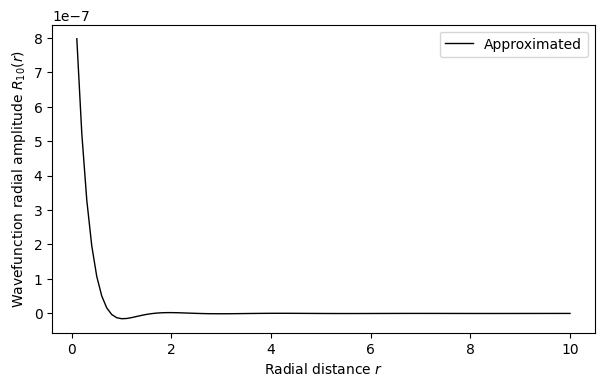

In [14]:
X = np.linspace(0.1,L/2,100) # avoid division by zero
y = (get_psi(c[-1]))(X)

fig, ax1 = plt.subplots(figsize=(7, 4))

# ax2 = ax1.twinx()

# ax2.set_ylim(-32, 32)

ax1.set_xlabel(r'Radial distance $r$')
ax1.set_ylabel(r'Wavefunction radial amplitude $R_{10}(r)$')
# ax2.set_ylabel(r'Approximation error ($10^{-5}$)')

colors = plt.cm.viridis([.5, .2, .8, .9])

# p1 = ax1.plot(X, y3, color=colors[0], ls='-', alpha=0.3, lw=5, label='Analytical')
# p2 = ax1.plot(X, y2, color=colors[1], ls='-', alpha=0.5, lw=3, label='Exact coefficients')
p3 = ax1.plot(X, y, color='k', ls='-', lw=1, label='Approximated')

# p4 = ax2.plot(X, (y2 - y3) * 100000, color=colors[2], ls='-', label='Error: Exact coeff.')
# p5 = ax2.plot(X, (y - y3) * 100000, color=colors[3], ls='-', label='Error: Approx.')

ax1.legend(handles=p3, loc='best')